# **TP - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 1 - Sistema de Tráfego**

In [4]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

$\quad$ Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido . O grafo tem de ser ligado o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.<br>
$\quad$ 1. Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.<br>
$\quad$ 2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

## Funções para gerar digrafo conexo

### Variaveis Globais

$NUM\_NODES =$ Número de nodos do digrafo.<br>
$MAX\_OUT\_DEGREE =$ Número maximo de descendentes de cada nodo

In [7]:
NUM_NODES = 32 
MAX_OUT_DEGREE = 3 

### Metodo 1

$\quad$ Neste metodo de geração do digrafo a estrategia utilizada consiste em manter manter sempre o digrafo conexo à medida que se vão adicionando arestas. Chamemos ao digrafo que vamos gerar **G**.<br>
$\quad$ Em primeiro lugar, inserimos todos os nodos [$n_1..n_j$] em **G**. De seguida, selecionamos de forma aleatoria dois nodos, aos quais chamemos **s** e **d** e adicionamos as arestas (**s**,**d**) e (**d**,**s**) a **G**. Apartir daqui, vamos ligando cada um dos nodos restantes a **G** de uma forma aleatoria, mas que mantenha sempre **G** conexo. Assim sendo, selecionamos um nodo **n** que ainda nao tem arestas e dois nodos, **s** e **d**, que ja se encontram na parte de **G** conexo. Aqui, existem duas opções:<br>
$\quad$ a. Se **s** ja tiver um grau de saida superior ao que foi definido, selecionamos outro nodo **d** que seja sucessor de **s**, removemos a aresta (**s**,**d**) e colocamos as arestas (**s**,**n**) e (**n**,**d**).<br>
$\quad$ b. Se **s** não tiver um grau de saida superior ao que foi definido, de forma aleatoriamente escolhida fazemos uma de duas coisas. Ou colocamos as arestas (**s**,**n**) e (**n**,**d**) ou então fazemos o mesmo processo definido no ponto a.<br>
$\quad$ Por fim iteramos por todos os nodos e adicionamos as restantes arestas de forma a satisfazer as condições do enunciado.

In [3]:
def graph_generator():
    G = nx.DiGraph()

    nodes = [n for n in range(1,NUM_NODES+1)]
    choosen = []
    G.add_nodes_from(nodes)
    random.shuffle(nodes)
    
    s = random.choice(nodes)
    nodes.remove(s)
    choosen.append(s)
    d = random.choice(nodes)
    nodes.remove(d)
    choosen.append(d)
    
    G.add_edge(s,d)
    G.add_edge(d,s)
    
    while nodes:
        to_add = random.choice(nodes)
        nodes.remove(to_add)
        s = random.choice(choosen)
        d = random.choice(choosen)
        if G.out_degree(s) == MAX_OUT_DEGREE or random.choice([0,1]):
            d = random.choice(list(G.successors(s)))
            G.remove_edge(s,d)
            G.add_edge(s,to_add)
            G.add_edge(to_add,d)
        else:
            G.add_edge(s,to_add)
            G.add_edge(to_add,s)
        choosen.append(to_add)
    
    nodes = [n for n in G.nodes() if G.out_degree(n)<MAX_OUT_DEGREE]
    while nodes:
        s = nodes.pop()
        r = random.randint(0,MAX_OUT_DEGREE - G.out_degree(s))
        candidates = [n for n in G.nodes() if n != s]
        for i in range(r):
            d = random.choice(candidates)
            candidates.remove(d)
            G.add_edge(s,d)
            
    return G

### Metodo 2

$\quad$ Neste metodo, mais simples que o anterior, criamos o digrado **G** e adicionamos todos os nodos [ 𝑛1..𝑛𝑗 ] em **G**. De seguida adicionamos as arestas <br>($n_1, n_2$), ($n_2, n_3$)...($n_{j-1}, n_j$) e ($n_j, n_1$). Isto vai criar um ciclo. Por fim, iteramos por todos os nodos e adicionamos as restantes arestas de forma a satisfazer as condições do enunciado. 

In [18]:
def graph_generator_simple():
    G = nx.DiGraph()

    nodes = [v for v in range(1,NUM_NODES+1)]
    G.add_nodes_from(nodes)
    random.shuffle(nodes)

    for i in range(len(nodes)-1):
        G.add_edge(nodes[i], nodes[i+1])
    G.add_edge(nodes[len(nodes)-1],nodes[0])

    for n in nodes:
        candidates = [v for v in nodes if v != n]
        random.shuffle(candidates)
        num_adj = random.randint(0,MAX_OUT_DEGREE-1)
        for i in range(num_adj):
            G.add_edge(n, candidates[i])
    return G

### Função para gerar subdigrafo conexo minimal

In [19]:
def sub_graph_generator(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    A = {}
    
    for edge in G.edges():
        A[edge] = solver.BoolVar('%i%i' %edge)
    
    
    
    nodes = [e for e in G.nodes()]
    s = nodes.pop(0)
    
    P = {}
    
    #garantir que de s conseguimos chegar a todos os outros nodos d e de todos os nodos d chegamos a s
    
    for d in nodes:
        
        #garantir que ha caminho de s para d
        
        paths = list(nx.all_simple_edge_paths(G, s, d))
        N = len(paths)
        for i in range(N):
            P[(s,d,i)] = solver.BoolVar('%i%i%i' %(s,d,i))
            for edge in paths[i]:
                solver.Add(P[(s,d,i)] <= A[edge])
        solver.Add(sum([P[(s,d,i)] for i in range(N)])>=1)
        
        #garantir que ha caminho de d para s
        
        paths = list(nx.all_simple_edge_paths(G, d, s))
        N = len(paths)
        for i in range(N):
            P[(d,s,i)] = solver.BoolVar('%i%i%i' %(d,s,i))
            for edge in paths[i]:
                solver.Add(P[(d,s,i)] <= A[edge])
        solver.Add(sum([P[(d,s,i)] for i in range(N)])>=1)
            
        
    
    solver.Minimize(sum([A[edge] for edge in G.edges]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        S = nx.DiGraph()
        S.add_nodes_from(G.nodes())
        for edge in A:
            if A[edge].solution_value() == 1:
                S.add_edge(edge[0],edge[1])
        return S
    else:
        print("Sem solução")
                
                
    

### Testes

#### Gerar Grafo

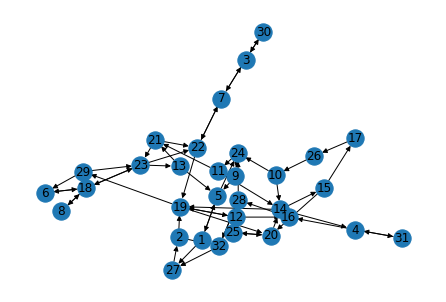

In [20]:
G1 = graph_generator()
nx.draw(G1, with_labels = True)

#### Verificar se é conexo 

In [21]:
nx.is_strongly_connected(G1)

True

#### Gerar Subgrafo minimal

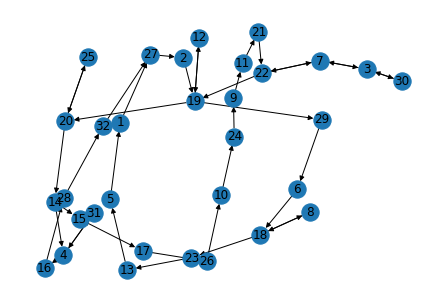

In [22]:
S1 = sub_graph_generator(G1)
nx.draw(S1, with_labels = True)

#### Verificar se é conexo 

In [23]:
nx.is_strongly_connected(S1)

True

#### Nº de arestas removidas

In [24]:
print(len(G1.edges()) - len(S1.edges()))

18


#### Gerar Grafo com a função que cria primeiro um ciclo

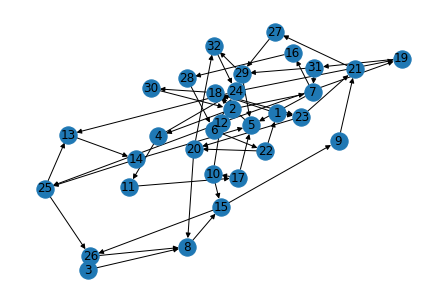

In [25]:
G2 = graph_generator_simple()
nx.draw(G2, with_labels = True)

#### Verificar se é conexo 

In [26]:
nx.is_strongly_connected(G2)

True

#### Gerar Subgrafo minimal

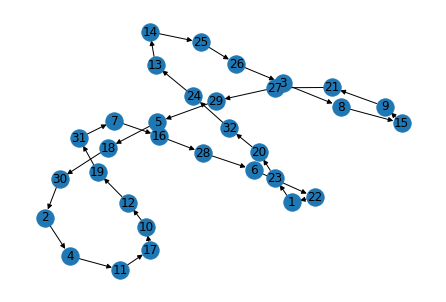

In [27]:
S2 = sub_graph_generator(G2)
nx.draw(S2, with_labels = True)

#### Verificar se é conexo 

In [28]:
nx.is_strongly_connected(S2)

True

#### Nº de arestas removidas

In [29]:
print(len(G2.edges()) - len(S2.edges()))

19
